# Analyse de sentiments binaires avec un LSTM implémenté en Pytorch

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
import tiktoken
from tqdm.auto import tqdm
from my_helper_functions import accuracy_fn, train_step, test_step, plot_training_data

print(f"PyTorch version : {torch.__version__}")

PyTorch version : 2.7.0+cu118


## Constantes

### On utilise la carte graphique (le GPU)

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

cuda


In [ ]:
MAX_LENGTH = 512
RANDOM_STATE = 42
BATCH_SIZE = 32

## Obtenir les data de IMDB

In [3]:
imdb = load_dataset("imdb")
print(imdb.shape)

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}


In [4]:
text, label = imdb["train"]["text"], imdb["train"]["label"]
text[:2], label[:2]

(['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, 

In [ ]:
train_split = imdb["train"].train_test_split(test_size=0.1, seed=RANDOM_STATE)
train_data = list(zip(train_split["train"]["text"], train_split["train"]["label"]))
valid_data = list(zip(train_split["test"]["text"],  train_split["test"]["label"]))
print(f"train : {len(train_data)} | valid : {len(valid_data)}")


train : 22500 | valid : 2500


In [6]:
train_data[:2]

[("With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old film of countries is nice, but the animal abuse and degradation of natives is painful to watch in these films. I know, racism is OK in these old films, but there is more to that to make this couple lose credibility. Portrayed as fliers, they never flew their planes, Martin Johnson was an ex-vaudevillian, used friends like Jack London for financial gain while stiffing them of royalties, denying his wife's apparent depression, using her as a cute prop, all this makes these films unbearable. They were by no means the first to travel to these lands, or the first to write about them. He was OK as a filmmaker and photographer, but that's about it.",
  0),
 ("I don't know the stars, or modern Chinese teenage music - but I do know a thoroughly entertaining movie when I see one.<br /><br />Kung 

In [7]:
tokenizer = tiktoken.get_encoding("o200k_base")
SPECIAL_EOT = "<|endoftext|>"
PAD_ID = tokenizer.encode(SPECIAL_EOT, allowed_special={SPECIAL_EOT})[0]

In [ ]:
def encode(text):
    token_ids = tokenizer.encode(text)[:MAX_LENGTH]
    return token_ids, len(token_ids)

In [9]:
train_pairs = [(encode(sequence)) + (label,) for sequence, label in train_data]  # (token_ids, length, label)
valid_pairs = [(encode(sequence)) + (label,) for sequence, label in valid_data]


In [10]:
def collate(batch):
    token_ids, seq_length, labels = zip(*batch) # three tuples
    seq_length = torch.tensor(seq_length)
    max_seq_lenght = seq_length.max()
    
    pad_tensor = torch.full((len(batch), max_seq_lenght), PAD_ID, dtype=torch.long)
    for i, seq in enumerate(token_ids):
        pad_tensor[i, :len(seq)] = torch.tensor(seq)
    
    return (pad_tensor.to(DEVICE),
            seq_length.to(DEVICE),
            torch.tensor(labels, dtype=torch.float32).to(DEVICE))


In [ ]:
train_loader = DataLoader(train_pairs, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_pairs, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

In [12]:
x, seq_lenght, y = next(iter(train_loader))
print(x.shape, seq_lenght[:3], y[:3])

torch.Size([32, 512]) tensor([ 52, 412, 143], device='cuda:0') tensor([0., 0., 1.], device='cuda:0')


In [13]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, emb=256, hid=192, bidirectional=True):
        super().__init__()
        self.num_dir = 2 if bidirectional else 1
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(emb, hid, batch_first=True, bidirectional=bidirectional)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(hid * self.num_dir, 1)

    def forward(self, x, lengths):
        x = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h, _) = self.lstm(packed)
        h = h.transpose(0, 1).contiguous().view(x.size(0), -1)
        h = self.drop(h)
        return self.fc(h).squeeze(1)


In [14]:
model = SentimentLSTM(tokenizer.n_vocab).to(DEVICE)

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} parameters")

51,896,449 parameters


In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)

In [ ]:
epochs = 5
train_loss_array = []
train_accuracy_array = []
valid_loss_array = []
valid_accuracy_array = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(dataloader=train_loader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=DEVICE
    )
    train_loss_array.append(train_loss.detach().cpu().numpy())
    train_accuracy_array.append(train_acc)

    valid_loss, valid_acc = test_step(dataloader=valid_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=DEVICE
    )
    valid_loss_array.append(valid_loss.detach().cpu().numpy())
    valid_accuracy_array.append(valid_acc)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.61502 | Train accuracy: 64.36%
Test loss: 0.66643 | Test accuracy: 60.72%

Epoch: 1
---------
Train loss: 0.41723 | Train accuracy: 80.96%
Test loss: 0.31125 | Test accuracy: 87.03%

Epoch: 2
---------
Train loss: 0.29455 | Train accuracy: 88.16%
Test loss: 0.28256 | Test accuracy: 88.65%

Epoch: 3
---------
Train loss: 0.24983 | Train accuracy: 90.37%
Test loss: 0.26848 | Test accuracy: 88.29%

Epoch: 4
---------
Train loss: 0.21217 | Train accuracy: 91.82%
Test loss: 0.30153 | Test accuracy: 88.77%



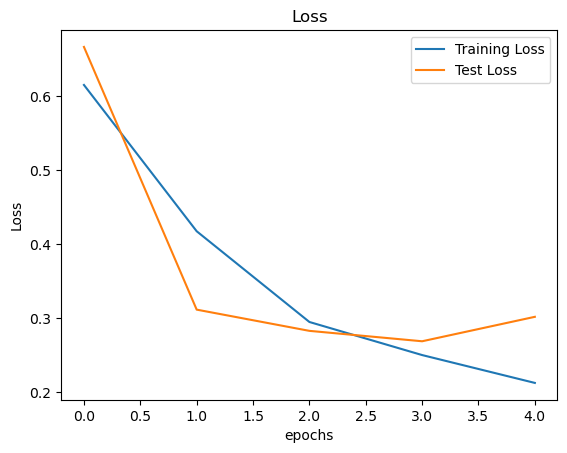

In [18]:
plot_training_data("Loss", train_loss_array, valid_loss_array)

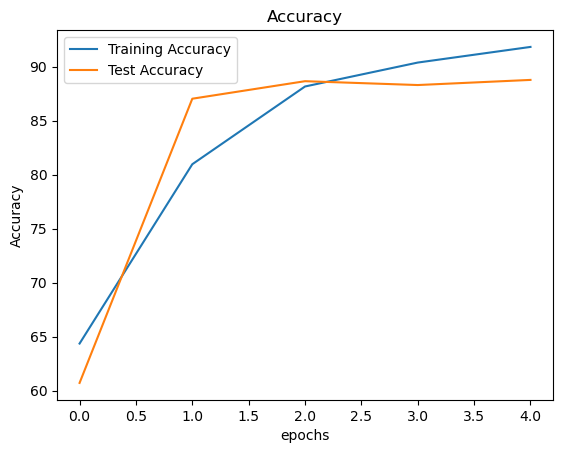

In [19]:
plot_training_data("Accuracy", train_accuracy_array, valid_accuracy_array)

In [20]:
torch.save(model.state_dict(), "lstm.pt")

In [ ]:
def predict_sentiment(text, model_path="lstm.pt", max_len=MAX_LENGTH, threshold=0.5):
    # encode & pad
    ids = tokenizer.encode(text)[:max_len]
    seq_lengths = torch.tensor([len(ids)])
    padded_ids = torch.tensor(ids + [PAD_ID] * (max_len - len(ids))).unsqueeze(0)
    padded_ids, seq_lengths = padded_ids.to(DEVICE), seq_lengths.to(DEVICE)

    # reload model (fresh instance → load weights)
    model = SentimentLSTM(tokenizer.n_vocab).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))

    # forward pass (no_grad = faster / lighter)
    model.eval()
    with torch.inference_mode():
        logit = model(padded_ids, seq_lengths)
        prob = torch.sigmoid(logit).item()

    label = "👍 positive" if prob >= threshold else "👎 negative"
    return label, round(prob, 2)

In [22]:
predict_sentiment("That plot twist slapped harder than my rent.")

('👎 negative', 0.33)

In [23]:
predict_sentiment("I’d rather eat a keyboard than rewatch this.")

('👎 negative', 0.11)

In [24]:
predict_sentiment("It is the best movie I ever seen !")

('👍 positive', 0.99)

In [25]:
predict_sentiment("The story was basic, and the direction academic, but it was still good entertainment.")

('👍 positive', 0.98)

In [26]:
predict_sentiment("Despite good photography, it is not the film of the century.")

('👍 positive', 0.86)

## Evaluation final avec les données de test

In [28]:
# build (token_ids, length, label) triples
test_text, test_label = imdb["test"]["text"], imdb["test"]["label"]
test_pairs = [(encode(sequence)) + (label,) for sequence, label in zip(test_text, test_label)]

# loader (same batch size / collate)
test_loader = DataLoader(test_pairs, batch_size=32, shuffle=False, collate_fn=collate)

# evaluate
test_loss, test_acc = test_step(
    model=model,
    dataloader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=DEVICE
)

print(f"\nIMDb official test | loss {test_loss:.4f} | acc {test_acc:.2f}%")


Test loss: 0.31340 | Test accuracy: 88.06%


IMDb official test | loss 0.3134 | acc 88.06%
